In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import arch.data.sp500
import matplotlib.gridspec as gridspec

In [2]:
name = ['AAPL from 2012 to 2018', 'AAPL from 2012 to 2018', 'AAPL from 2016 to 2018', 'AAPL from 2016 to 2018']
data1 = yf.download('AAPL','2012-01-01','2018-01-01')
data2 = yf.download('AAPL', '2012-01-01', '2018-01-01')
data3 = yf.download('AAPL', '2016-01-01', '2018-01-01')
data4 = yf.download('AAPL', '2016-01-01', '2018-01-01')

data = [data1, data2, data3, data4]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
N_TEST = 30
VOL_SIZE = 30

In [4]:
def create_volatility(prices, period):
    return pd.Series(prices.rolling(period).std(ddof=1), index=prices.index)

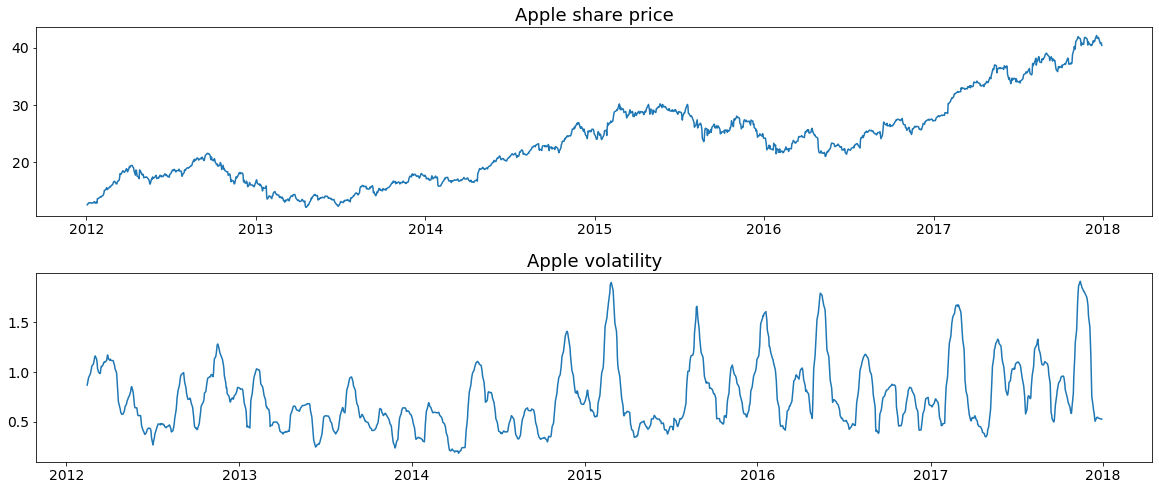

In [5]:
gs = gridspec.GridSpec(2, 1, hspace=0.3)
plt.figure(figsize=(20, 8))
volatility = create_volatility(data[0]['Adj Close'], VOL_SIZE)
ax = plt.subplot(gs[0, 0])
ax.plot(data[0]['Adj Close'])
plt.title('Apple share price', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
ax = plt.subplot(gs[1, 0])
ax.plot(volatility)
volatility = volatility.dropna()
plt.title('Apple volatility', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [6]:
returns = []
for i in range(len(name)):
    returns.append(100 * data[i]['Adj Close'].pct_change().dropna())
#returns = volatility

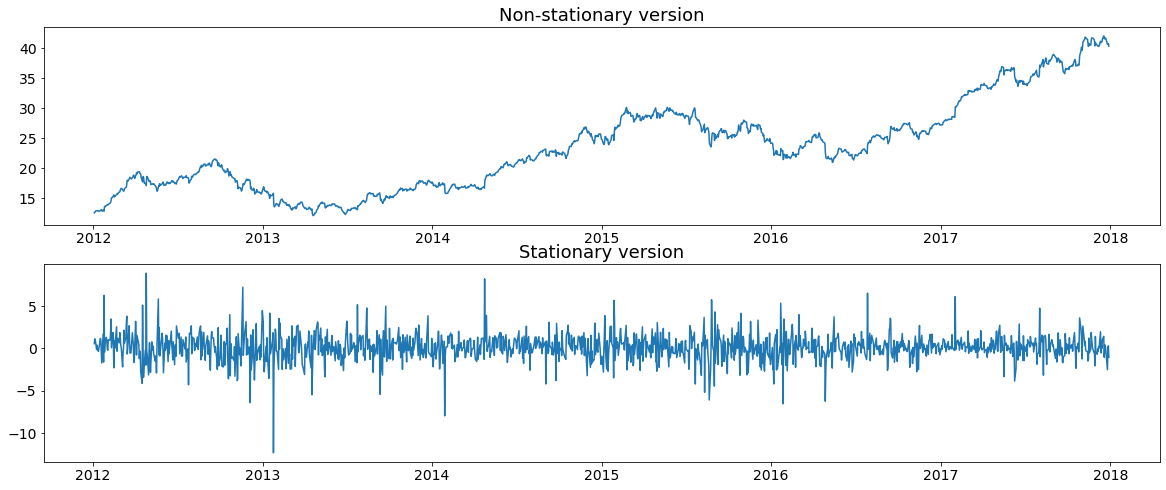

In [7]:
gs = gridspec.GridSpec(2, 1, hspace=0.2)
plt.figure(figsize=(20, 8))
volatility = create_volatility(data[0]['Adj Close'], VOL_SIZE)
ax = plt.subplot(gs[0, 0])
ax.plot(data[0]['Adj Close'])
plt.title('Non-stationary version', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
ax = plt.subplot(gs[1, 0])
ax.plot(returns[0])
plt.title('Stationary version', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [8]:
volatility = []
for i in range(len(name)):
    volatility.append(create_volatility(returns[i], VOL_SIZE).dropna())

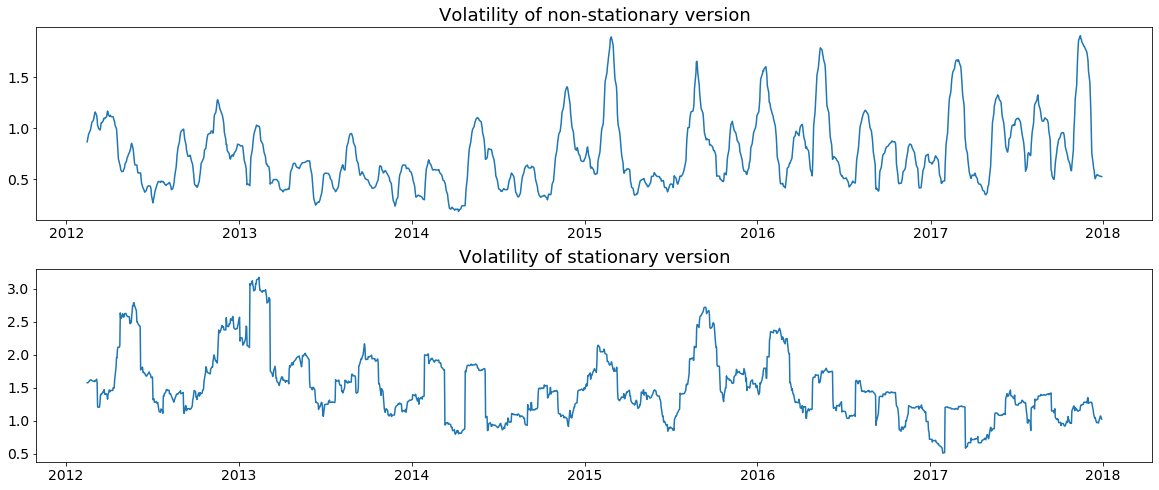

In [9]:
gs = gridspec.GridSpec(2, 1, hspace=0.25)
plt.figure(figsize=(20, 8))
ax = plt.subplot(gs[0, 0])
ax.plot(create_volatility(data[0]['Adj Close'], VOL_SIZE))
plt.title('Volatility of non-stationary version', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
ax = plt.subplot(gs[1, 0])
ax.plot(volatility[0])
plt.title('Volatility of stationary version', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

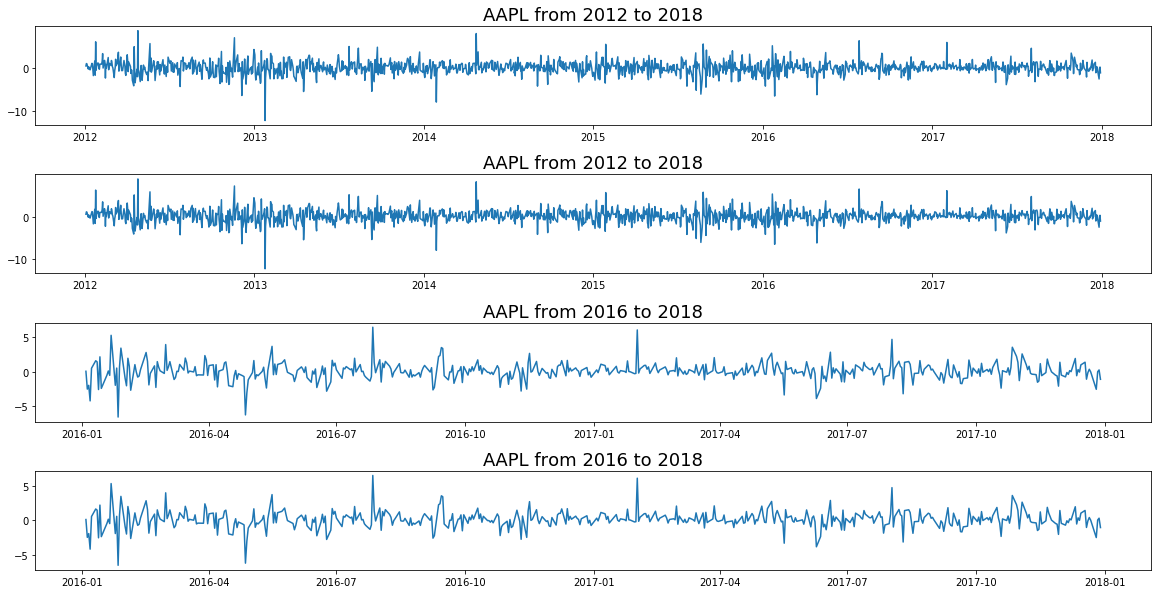

In [10]:
# gs = gridspec.GridSpec(len(name), 1, hspace=0.5)
# plt.figure(figsize=(20, 10))
# for i in range(len(name)):
#     ax1 = plt.subplot(gs[i, 0])
#     ax1.plot(returns[i])
#     ax1.set_title(name[i], fontsize=18)
# plt.show()

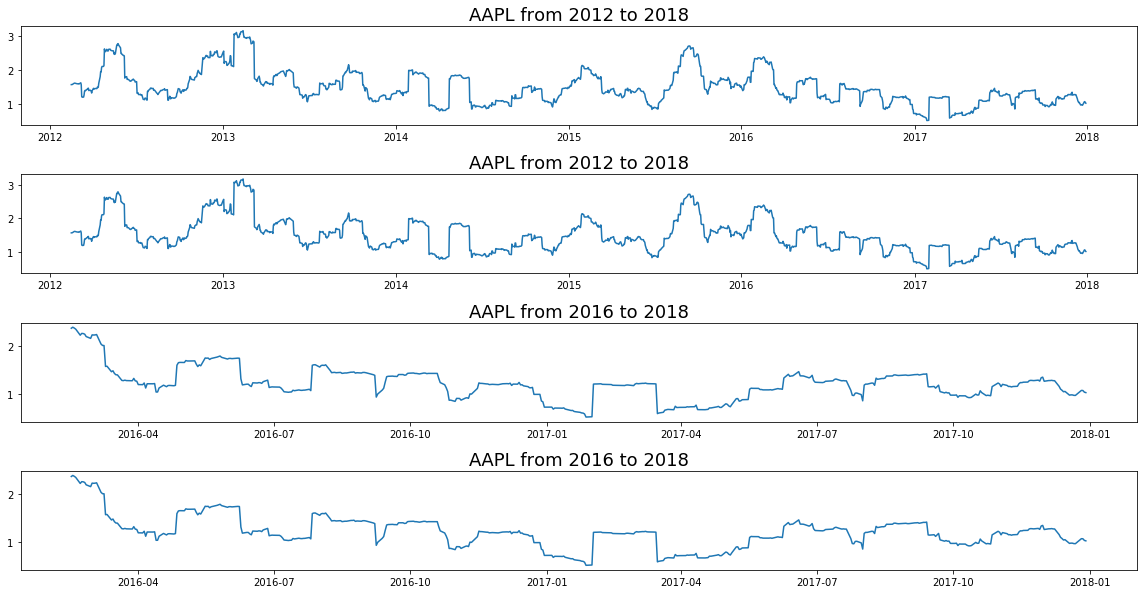

In [11]:
# gs = gridspec.GridSpec(4, 1, hspace=0.5)
# plt.figure(figsize=(20, 10))
# for i in range(len(name)):
#     ax1 = plt.subplot(gs[i, 0])
#     ax1.plot(volatility[i])
#     ax1.set_title(name[i], fontsize=18)
# plt.show()

In [12]:
import statsmodels.tsa.api as tsa

def build_Arma(data, p, q):
    train = data[:- N_TEST]
    test = data[- N_TEST:]
    arma = tsa.ARMA(train.values, order=(p,q)).fit()
    start = len(train)
    end = len(train) + N_TEST - 1
    a = pd.Series(arma.predict(start, end), index=test.index)
    return a, test

0


/Users/millb/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/millb/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1
2


/Users/millb/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3


/Users/millb/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


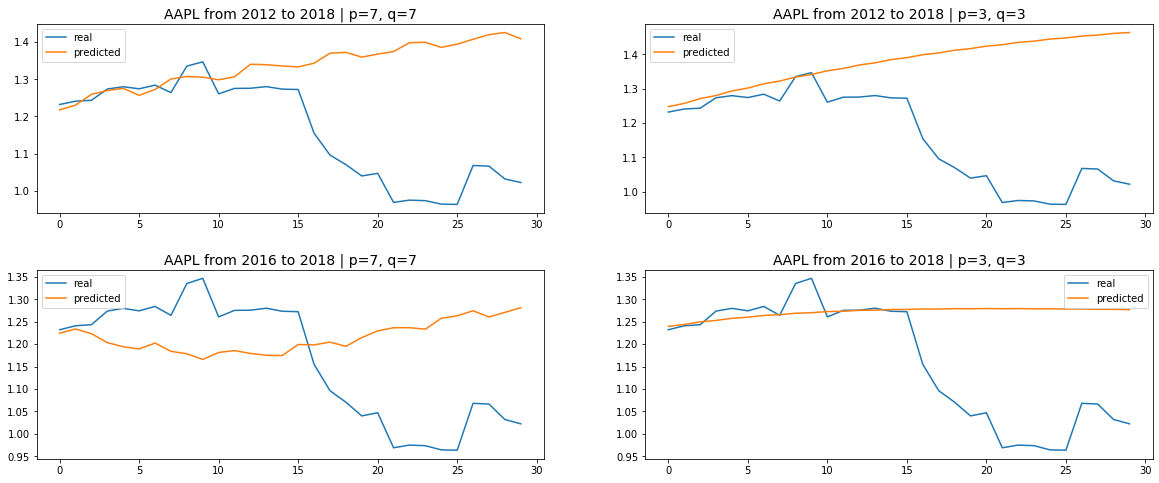

In [13]:
gs = gridspec.GridSpec(2, 2, hspace=0.3)
plt.figure(figsize=(20, 8))
for i in range(0, 4):
    print(i)
    predicted, test = build_Arma(volatility[i], 7 // (i%2+1),7 // (i%2+1))
    ax1 = plt.subplot(gs[i // 2, i % 2])
    ax1.plot(test.values, label='real')
    ax1.plot(predicted.values, label='predicted')
    ax1.set_title(name[i] + ' | p=' + str(7 // (i%2+1)) + ', q=' + str(7 // (i%2+1)), fontsize=14)
    ax1.legend()
    #plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


In [14]:
from arch import arch_model

def build_garch(i, p, q):
    train, test = returns[i][:-N_TEST], returns[i][-N_TEST:]
    #train, test = data['Adj Close'][:-n_test], data['Adj Close'][-n_test:]
    #train, test = volatility[:-n_test], volatility[-n_test:]
    # model = arch_model(train, vol='Garch', p=30, o=0, q=30, dist='Normal').fit(update_freq=10)
    # predicted = pd.Series(model.forecast(horizon=n_test).variance.values[-1:][0], index=test.index)
    model = arch_model(train, mean='Zero', vol='GARCH', p=p, q=q)
    model_fit = model.fit(update_freq=100)
    predicted = pd.Series(np.sqrt(model_fit.forecast(horizon=N_TEST).variance.values[-1:][0]), index=test.index)
    return predicted

0
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2698.1844647542603
            Iterations: 59
            Function evaluations: 3737
            Gradient evaluations: 58
1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2709.777379220437
            Iterations: 33
            Function evaluations: 1092
            Gradient evaluations: 32
2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 762.0165162250225
            Iterations: 56
            Function evaluations: 3470
            Gradient evaluations: 54
3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 778.1678544422887
            Iterations: 42
            Function evaluations: 1364
            Gradient evaluations: 40


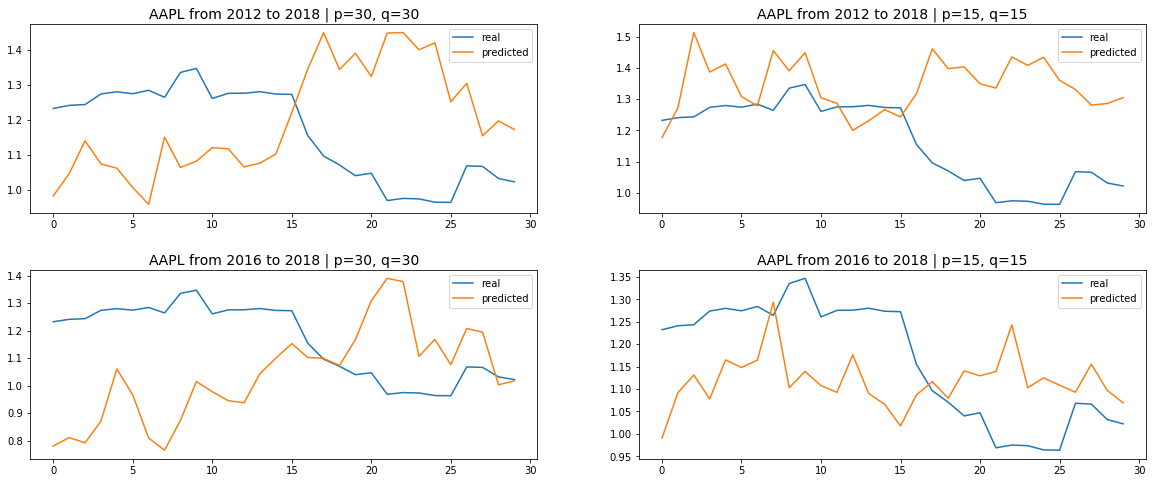

In [15]:
gs = gridspec.GridSpec(2, 2, hspace=0.3)
plt.figure(figsize=(20, 8))
for i in range(0, 4):
    print(i)
    predicted = build_garch(i, 30 // (i%2+1), 30 // (i%2+1))
    ax1 = plt.subplot(gs[i // 2, i % 2])
    ax1.plot(volatility[i][-N_TEST:].values, label='real')
    ax1.plot(predicted.values, label='predicted')
    ax1.legend()
    ax1.set_title(name[i] + ' | p=' + str(30 // (i%2+1)) + ', q=' + str(30 // (i%2+1)), fontsize=14)
    #plt.tick_params(axis='y', which='major', labelsize=14)
plt.show()


0
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2727.888616870543
            Iterations: 16
            Function evaluations: 126
            Gradient evaluations: 16
1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2722.5833798292783
            Iterations: 20
            Function evaluations: 276
            Gradient evaluations: 20
2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2721.2654459069477
            Iterations: 28
            Function evaluations: 670
            Gradient evaluations: 28
3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2709.777379220437
            Iterations: 33
            Function evaluations: 1092
            Gradient evaluations: 32
4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2698.1844647542603
            Iterations: 59
      

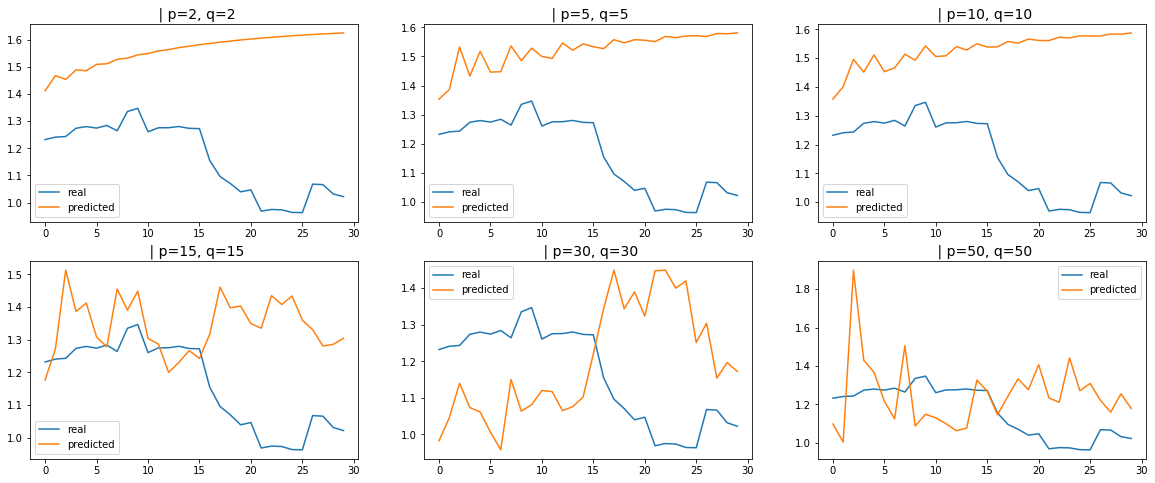

In [16]:
gs = gridspec.GridSpec(2, 3)
plt.figure(figsize=(20, 8))
for i, p in enumerate([2, 5, 10, 15, 30, 50]):
    print(i)
    predicted = build_garch(0, p, p)
    ax1 = plt.subplot(gs[i // 3, i % 3])
    ax1.plot(volatility[0][-N_TEST:].values, label='real')
    ax1.plot(predicted.values, label='predicted')
    ax1.legend()
    ax1.set_title(' | p=' + str(p) + ', q=' + str(p), fontsize=14)
    #plt.tick_params(axis='y', which='major', labelsize=14)
plt.show()

0
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2721.701252525904
            Iterations: 24
            Function evaluations: 503
            Gradient evaluations: 24
1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2720.8617467673075
            Iterations: 29
            Function evaluations: 692
            Gradient evaluations: 29
2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2720.688436661568
            Iterations: 30
            Function evaluations: 844
            Gradient evaluations: 29
3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2709.777379220437
            Iterations: 33
            Function evaluations: 1092
            Gradient evaluations: 32
4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2708.079444100001
            Iterations: 29
        

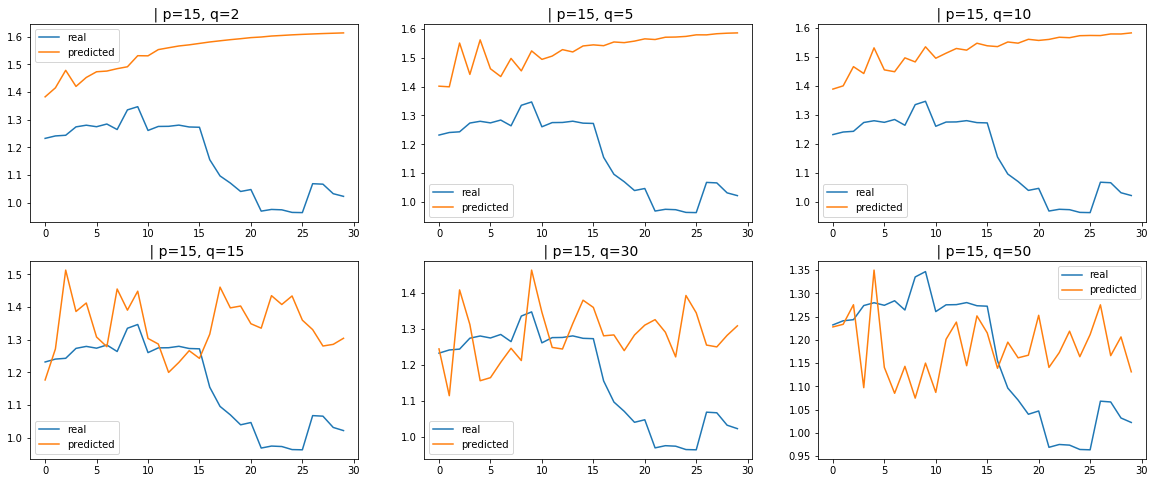

In [17]:
gs = gridspec.GridSpec(2, 3)
plt.figure(figsize=(20, 8))
for i, p in enumerate([2, 5, 10, 15, 30, 50]):
    print(i)
    predicted = build_garch(0, 15, p)
    ax1 = plt.subplot(gs[i // 3, i % 3])
    ax1.plot(volatility[0][-N_TEST:].values, label='real')
    ax1.plot(predicted.values, label='predicted')
    ax1.legend()
    ax1.set_title(' | p=' + str(15) + ', q=' + str(p), fontsize=14)
    #plt.tick_params(axis='y', which='major', labelsize=14)
plt.show()

0
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2715.8077432843174
            Iterations: 23
            Function evaluations: 479
            Gradient evaluations: 23
1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2713.327248157955
            Iterations: 30
            Function evaluations: 717
            Gradient evaluations: 30
2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2709.7773780866714
            Iterations: 30
            Function evaluations: 869
            Gradient evaluations: 30
3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2709.777379220437
            Iterations: 33
            Function evaluations: 1092
            Gradient evaluations: 32
4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2710.6734779341177
            Iterations: 37
      

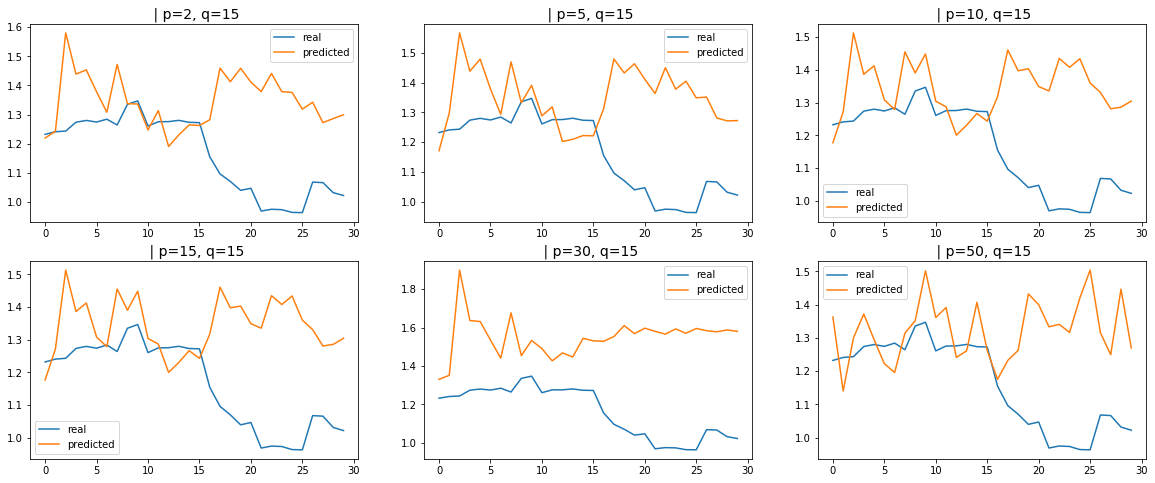

In [18]:
gs = gridspec.GridSpec(2, 3)
plt.figure(figsize=(20, 8))
for i, p in enumerate([2, 5, 10, 15, 30, 50]):
    print(i)
    predicted = build_garch(0, p, 15)
    ax1 = plt.subplot(gs[i // 3, i % 3])
    ax1.plot(volatility[0][-N_TEST:].values, label='real')
    ax1.plot(predicted.values, label='predicted')
    ax1.legend()
    ax1.set_title(' | p=' + str(p) + ', q=' + str(15), fontsize=14)
    #plt.tick_params(axis='y', which='major', labelsize=14)
plt.show()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2598.1927958204396
            Iterations: 36
            Function evaluations: 1192
            Gradient evaluations: 35


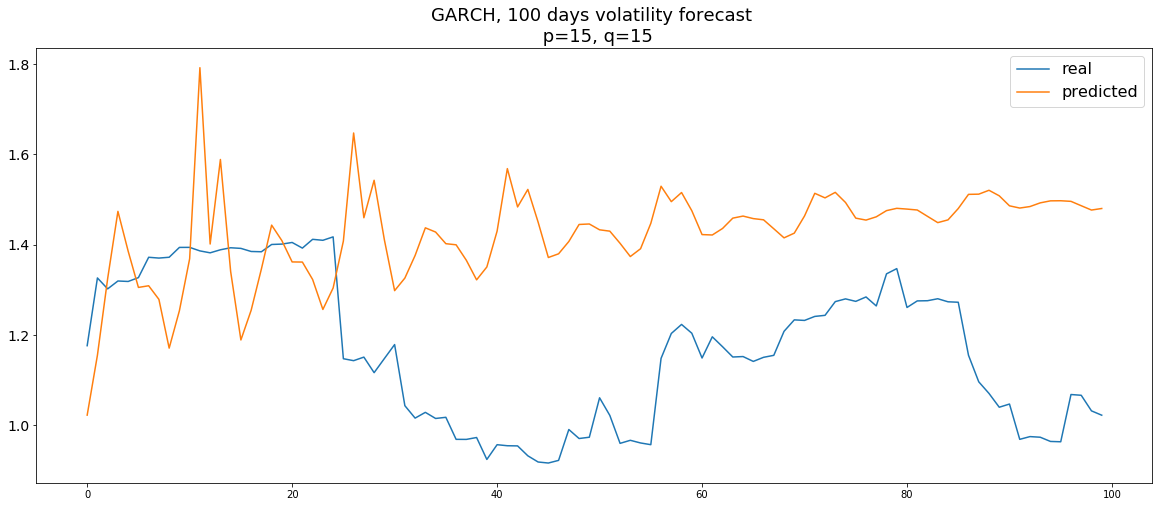

In [19]:
N_TEST = 100

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 1, 1)
predicted = build_garch(0, 15, 15)
ax1.plot(volatility[0][-N_TEST:].values, label='real')
ax1.plot(predicted.values, label='predicted')
ax1.legend(fontsize=16)
ax1.set_title('GARCH, 100 days volatility forecast \n p=' + str(15) + ', q=' + str(15), fontsize=18)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.show()

/Users/millb/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


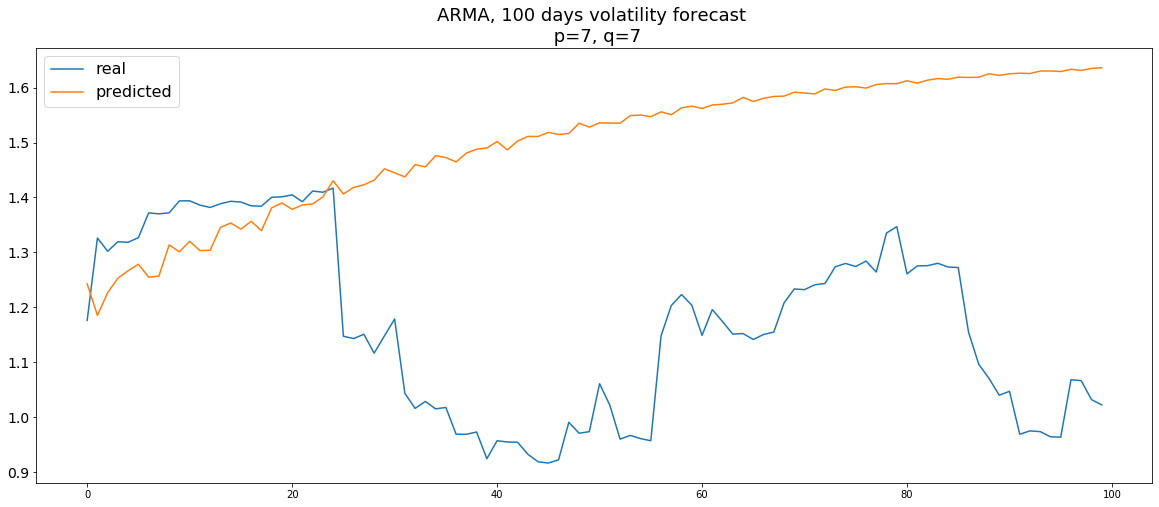

In [21]:
N_TEST = 100

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 1, 1)
predicted, test = build_Arma(volatility[0], 7, 7)
ax1.plot(test.values, label='real')
ax1.plot(predicted.values, label='predicted')
ax1.legend(fontsize=16)
ax1.set_title('ARMA, 100 days volatility forecast \n p=' + str(7) + ', q=' + str(7), fontsize=18)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.show()